# Init


In [ ]:
!pip install -q torch torchvision torch-geometric neptune torch-scatter dotmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 KB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_scatter
import random

# Neptune
import neptune

# Pytorch Geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models

## GIN (GINMPNN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

class GINLayer(MessagePassing):
    def __init__(self, in_features, out_features, eps=0):
        super(GINLayer, self).__init__(aggr='add')
        self.mlp = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
        )
        self.eps = eps

    def forward(self, x, adj):
        edge_index = adj.nonzero().t()
        edge_weight = torch.ones((edge_index.size(1), ), dtype=torch.float32, device=x.device)
        x = self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x, edge_weight=edge_weight))
        return x

    def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j

class GINMPNN(nn.Module):
    def __init__(self, n_layers, in_features, hidden_features, out_features, dropout_p=0.5, eps=0):
        super(GINMPNN, self).__init__()
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        self.layers.append(GINLayer(in_features, hidden_features, eps=eps))
        for _ in range(n_layers - 2):
            self.layers.append(GINLayer(hidden_features, hidden_features, eps=eps))
        self.layers.append(GINLayer(hidden_features, out_features, eps=eps))

    def forward(self, x, adj):
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if i != len(self.layers):
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_p, training=self.training)
        return F.log_softmax(x, dim=1)


## GCN (GCNMPNN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

class GCNLayer(MessagePassing):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__(aggr='add')
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        edge_index = adj.nonzero().t()
        norm = torch.pow(adj.sum(dim=1).clamp(min=1), -0.5)
        edge_weight = torch.ones((edge_index.size(1),), dtype=torch.float32, device=x.device)
        edge_weight = edge_weight * norm[edge_index[0]] * norm[edge_index[1]]
        x = self.linear(x)
        x = self.propagate(edge_index, x=x, edge_weight=edge_weight)
        return x

    def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j

class GCNMPNN(nn.Module):
    def __init__(self, n_layers, in_features, hidden_features, out_features, dropout_p=0.5):
        super(GCNMPNN, self).__init__()
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        self.layers.append(GCNLayer(in_features, hidden_features))
        for _ in range(n_layers - 2):
            self.layers.append(GCNLayer(hidden_features, hidden_features))
        self.layers.append(GCNLayer(hidden_features, out_features))

    def forward(self, x, adj):
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if i != len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_p, training=self.training)
        return F.log_softmax(x, dim=1)


## GAT (GAT)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, heads=1, concat=True, dropout=0.6, alpha=0.2):
        super(GATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.heads = heads
        self.concat = concat
        self.dropout = dropout
        self.alpha = alpha

        self.W = nn.Linear(in_features, heads * out_features, bias=False)
        self.a = nn.Parameter(torch.zeros(size=(1, heads, 2 * out_features)))

        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, x, adj):
        x = self.W(x).view(-1, self.heads, self.out_features)
        N = x.size(0)

        a_input = (x.unsqueeze(1).repeat(1, N, 1, 1) * self.a[:, :, :self.out_features]).sum(dim=-1)
        a_input_T = (x.unsqueeze(0).repeat(N, 1, 1, 1) * self.a[:, :, self.out_features:]).sum(dim=-1)

        e = F.leaky_relu(a_input + a_input_T, self.alpha)
        e = F.dropout(e, p=self.dropout, training=self.training)
        e = torch.where(adj > 0, e, torch.zeros_like(e))

        e = F.softmax(e, dim=1)
        x_j = torch.matmul(e * adj.unsqueeze(-1).repeat(1, 1, self.heads), x)
        aggr_out = x_j

        if self.concat:
            return aggr_out.view(-1, self.heads * self.out_features)
        else:
            return aggr_out.mean(dim=1)

class GAT(nn.Module):
    def __init__(self, n_layers, in_features, hidden_features, out_features, heads=1, dropout_p=0.6, alpha=0.2):
        super(GAT, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GATLayer(in_features, hidden_features, heads=heads, dropout=dropout_p, alpha=alpha))
        for _ in range(n_layers - 2):
            self.layers.append(GATLayer(hidden_features * heads, hidden_features, heads=heads, dropout=dropout_p, alpha=alpha))
        self.layers.append(GATLayer(hidden_features * heads, out_features, heads=1, concat=False, dropout=dropout_p, alpha=alpha))

    def forward(self, x, adj):
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if i != len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_p, training=self.training)
        return F.log_softmax(x, dim=1)


# SCC - MPNN

## Preprocess

In [ ]:
import torch
import networkx as nx
from typing import Tuple
from networkx.algorithms.components.strongly_connected import strongly_connected_components

def get_scc_adj(adj: torch.Tensor) -> torch.Tensor:
    # Convert the PyTorch adjacency matrix to a NetworkX directed graph
    G = nx.from_numpy_array(adj.numpy(), create_using=nx.DiGraph())

    # Get the strongly connected components
    sccs = list(strongly_connected_components(G))

    # print("sccs:", sccs)
    sccs_distribution = [len(scc) for scc in sccs]

    # Create a new graph to store the SCC adjacency matrix
    H = nx.DiGraph()
    H.add_nodes_from(range(len(adj)))

    # Add edges between nodes in the same SCC
    for i, scc in enumerate(sccs):
        for u in scc:
            for v in scc:
                if u != v:
                    H.add_edge(u, v)

    # Convert the NetworkX SCC graph to a PyTorch adjacency matrix
    scc_adj = torch.tensor(nx.to_numpy_array(H), dtype=torch.float32)
    return scc_adj, len(sccs), sccs_distribution


### visualize_graph(adj, title)

tensor([[0., 1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 1., 0.]])


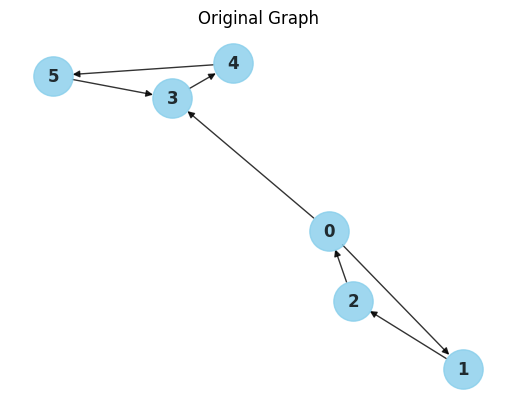

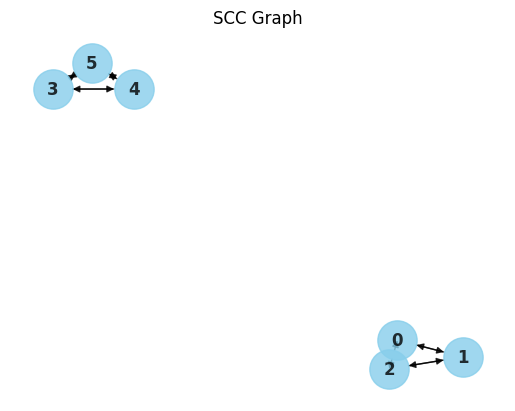

In [ ]:
import matplotlib.pyplot as plt

def visualize_graph(adj: torch.Tensor, title: str):
    G = nx.from_numpy_array(adj.numpy(), create_using=nx.DiGraph())
    pos = nx.spring_layout(G, seed=42)
    plt.figure()
    plt.title(title)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='black', node_size=800, alpha=0.8, font_weight='bold')
    plt.show()

# Example adjacency matrix
adj = torch.tensor([
    [0, 1, 0, 1, 0, 0],  # Node 0 connections
    [0, 0, 1, 0, 0, 0],  # Node 1 connections
    [1, 0, 0, 0, 0, 0],  # Node 2 connections
    [0, 0, 0, 0, 1, 0],  # Node 3 connections
    [0, 0, 0, 0, 0, 1],  # Node 4 connections
    [0, 0, 0, 1, 0, 0],  # Node 5 connections
], dtype=torch.float32)


scc_adj, scc_num, scc_distb = get_scc_adj(adj)
print(scc_adj)

visualize_graph(adj, "Original Graph")
visualize_graph(scc_adj, "SCC Graph")
# print(torch.diagonal(adj))

### generate_graph(scc_n, seed, min_scc_size, max_scc_size) -> (A,X)

[5, 5, 7, 6, 6, 6, 5]
IJDIJD torch.float32
torch.Size([40, 40]) torch.Size([40])


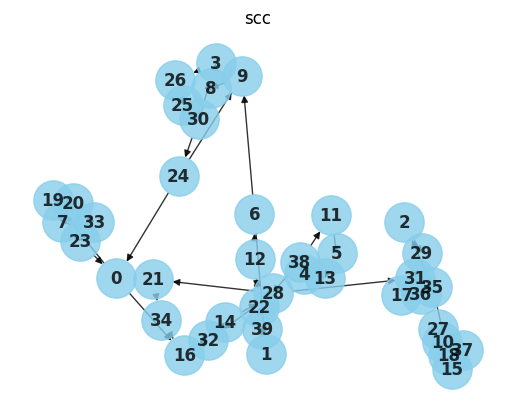

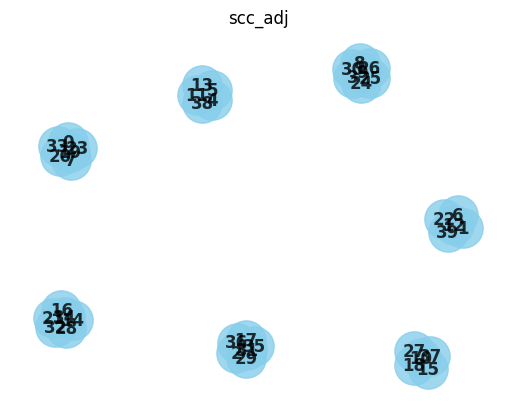

In [ ]:
import torch
import random

# def generate_scc(size, k, index):
#     scc = torch.zeros(size, size)
#     for i in range(size):
#         scc[i][(i + 1) % size] = 1
#     scc[-1][0] = 1

#     one_hot = torch.zeros(size, k)
#     one_hot[:, index] = 1

#     return scc, one_hot


def generate_scc(size, k, index):
    scc = torch.zeros(size, size)
    for i in range(size):
        scc[i][(i + 1) % size] = 1
    scc[-1][0] = 1

    # Add random edges within the SCC
    for i in range(size):
        connect = random.randint(0,size-1)
        if connect != i and (i+1)%size != connect:
            scc[i, connect] = random.choice([0, 1])

    one_hot = torch.zeros(size)
    one_hot[:] = k

    return scc, one_hot

def generate_graph(k, seed, min_scc_size, max_scc_size):
    random.seed(seed)
    torch.manual_seed(seed)

    # Get sizes for each scc
    scc_sizes = [random.randint(min_scc_size, max_scc_size) for _ in range(k)]
    print(scc_sizes)
    n = sum(scc_sizes)

    adj = torch.zeros((n, n))
    one_hot_scc = torch.zeros(n)
    node_index = 0

    for i, size in enumerate(scc_sizes):
        scc, one_hot = generate_scc(size, k, i)
        adj[node_index:node_index + size, node_index:node_index + size] = scc
        one_hot_scc[node_index:node_index + size] = one_hot
        node_index += size

    for i in range(k - 1):
        source_scc_start = sum(scc_sizes[:i])
        target_scc_start = sum(scc_sizes[:i + 1])
        source_node = random.randint(source_scc_start, source_scc_start + scc_sizes[i] - 1)
        target_node = random.randint(target_scc_start, target_scc_start + scc_sizes[i + 1] - 1)
        adj[source_node, target_node] = 1.0
    print("IJDIJD",one_hot_scc.dtype)
    return permute_matrices(adj, one_hot_scc, seed)

def permute_matrices(adj, x, seed):
    torch.manual_seed(seed)
    # Get the number of nodes
    n_nodes = adj.shape[0]

    # Create a random permutation of the nodes
    nodes_permutation = torch.randperm(n_nodes)

    # Create the permutation matrix P
    P = torch.eye(n_nodes)[nodes_permutation] # -> (n,n)

    # Permute the adjacency matrix
    adj_permuted = P @ adj @ P.T

    # Permute the feature matrix
    x_permuted = P @ x 

    return adj_permuted, x_permuted


# Example usage:
k = 7
seed = 42

# adj, one_hot = generate_scc(5, 1, 0)
adj, one_hot_scc = generate_graph(k, seed,5,8)
scc_adj, scc_num, scc_distb = get_scc_adj(adj)

print(adj.shape, one_hot_scc.shape)
visualize_graph(adj, "scc")
visualize_graph(scc_adj, "scc_adj")

## Network

$$
\mathbf{h}_u^{(t+1)}= \operatorname{MLP}\left((1+\epsilon) \mathbf{h}_u^{(t)}+\alpha\sum_{v \in \mathcal{N}(u)} \mathbf{h}_v^{(t)}  + (1-\alpha)\sum_{v \in H_u} \mathbf{h}_v^{(t)}\right)
$$

In [ ]:
import torch.nn as nn


class SCCLayer(MessagePassing):
    def __init__(self, in_features, out_features, eps, alpha):
        super(SCCLayer, self).__init__(aggr='add')
        self.mlp = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
        )
        self.eps = eps
        self.alpha = alpha

    def forward(self, x, adj, scc_adj):
        edge_index = adj.nonzero().t()
        edge_weight = torch.ones((edge_index.size(1), ), dtype=torch.float32, device=x.device)


        scc_adj_sparse = torch.sparse_coo_tensor(scc_adj.nonzero(), scc_adj[scc_adj.nonzero()], scc_adj.size())

        scc_edge_index = scc_adj_sparse.nonzero().t()
        scc_edge_weight = torch.ones((scc_edge_index.size(1), ), dtype=torch.float32, device=x.device)
        neighbourhood = self.propagate(edge_index, x=x, edge_weight=edge_weight)
        scc_neighbourhood = self.propagate(scc_edge_index, x=x, edge_weight=scc_edge_weight)
        x = self.mlp((1 + self.eps) * x + self.alpha * neighbourhood + (1-self.alpha) * scc_neighbourhood)
        return x
    
    def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j



class SCCMPNN(nn.Module):
    def __init__(self, n_layers, in_features, hidden_features, out_features, dropout_p=0.5, eps=0.0, alpha=0.5):
        super(SCCMPNN, self).__init__()
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()

        self.eps = nn.Parameter(torch.tensor([eps], dtype=torch.float32))
        self.alpha = nn.Parameter(torch.tensor([alpha], dtype=torch.float32))

        self.layers.append(SCCLayer(in_features, hidden_features, eps=self.eps, alpha=self.alpha))
        for _ in range(n_layers - 2):
            self.layers.append(SCCLayer(hidden_features, hidden_features, eps=self.eps, alpha=self.alpha))
        self.layers.append(SCCLayer(hidden_features, out_features, eps=self.eps, alpha=self.alpha))

    def forward(self, x, adj, scc_adj):
        for i, layer in enumerate(self.layers):
            print("layer 1")
            x = layer(x, adj, scc_adj)
            if i != len(self.layers):
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_p, training=self.training)
        return F.log_softmax(x, dim=1)


# class SCCLayer(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(SCCLayer, self).__init__()
#         self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
#         self.reset_parameters()

#     def reset_parameters(self):
#         nn.init.xavier_uniform_(self.weight)

#     def forward(self, x, adj, scc_adj):
#         # A @ X @ W
#         support = torch.mm(x, self.weight) # (n, in_features) @ (in_features, out_features) -> (n, out_features)
#         output = torch.mm(adj, support) # (n,n) @ (n, out_features) -> (n, out_features)
#         return output


# class SCCMPNN(nn.Module):
#     def __init__(self, n_layers, in_channels, hidden_channels, out_channels, dropout_p=0.5):
#         super(SCCMPNN, self).__init__()
#         self.dropout_p = dropout_p
#         self.layers = nn.ModuleList()
#         self.layers.append(SCCLayer(in_channels, hidden_channels))
#         for _ in range(n_layers - 2):
#             self.layers.append(SCCLayer(hidden_channels, hidden_channels))
#         self.layers.append(SCCLayer(hidden_channels, out_channels))

#     def forward(self, x, adj, scc_adj):
#         for i,layer in enumerate(self.layers):
#             x = layer(x, adj, scc_adj)

#             if i != len(self.layers):
#                 x = F.relu(x)
#                 x = F.dropout(x, p=self.dropout_p, training=self.training)
#         return F.log_softmax(x, dim=1)




# Utils

## get_model(params) -> Model

In [ ]:
def get_model(params):

    if params["model"]=="SCC-MPNN":
        model = SCCMPNN(params["num_layers"], params["in_channels"], params["hidden_channels"], params["out_channels"])
    if params["model"]=="GIN":
        model = GINMPNN(params["num_layers"], params["in_channels"], params["hidden_channels"], params["out_channels"])
    if params["model"]=="GAT":
        model = GAT(params["num_layers"], params["in_channels"], params["hidden_channels"], params["out_channels"])
    if params["model"]=="GCN":
        model = GCNMPNN(params["num_layers"], params["in_channels"], params["hidden_channels"], params["out_channels"])
    return model



# Data

## load_pyg_dataset(name, subcategory)

In [ ]:
from torch_geometric.datasets import TUDataset, WebKB, Planetoid, WikiCS, WikipediaNetwork, KarateClub, TUDataset, CitationFull
from torch_geometric.data import DataLoader
import torch_geometric
from dotmap import DotMap


def load_pyg_dataset(name, subcategory):
    
    # Load a PyTorch Geometric dataset 
    if name=="CitationFull":
        dataset = CitationFull(root="./CitationFull", name=subcategory)
    elif name=="WebKB":
        dataset = WebKB(root='./WebKB', name=subcategory)
    elif name=="WikiCS":
        dataset = WikiCS(root='./WikiCS')
    elif name=="WikipediaNetwork":
        dataset = WikipediaNetwork(root='./WikipediaNetwork', name=subcategory)
    elif name=="Planetoid":
        dataset = Planetoid(root="./Planetoid", name=subcategory)
    elif name=="KarateClub":
        dataset = KarateClub()
    elif name=="TUDataset":
        dataset = TUDataset(root="./TUDataset", name=subcategory)
    elif name=="CitationFull":
        datset = CitationFull(root="./CitationFull", name=subcategory)
    elif name.startswith("SCC"):
        pass
    else:
        raise ValueError("Data not Found")
    
    
    if name.startswith("SCC"):
        
        scc_size_max = int(name.split("-")[1])
        scc_size_min = scc_size_max
        scc_num = 10

        data = DotMap()
        dataset = DotMap()
        print("generating graph...")
        data.adj, data.y = generate_graph(scc_num,42,scc_size_min,scc_size_max)
        print(data.y.dtype)
        data.num_nodes = data.adj.shape[0]
        data.x = torch.ones((data.num_nodes,1))
        data.synthetic = True
        dataset.num_features = 1
        dataset.num_classes = scc_num
    else:
        # Get the data
        data = dataset[0]
        data.synthetic = False
    # Create training and testing masks
    train_ratio = 0.8
    train_num = int(train_ratio * data.num_nodes)
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[:train_num] = True
    test_mask[data.num_nodes - train_num:] = True
    data.train_mask = train_mask
    data.test_mask = test_mask

    return dataset,data

# data.y = F.one_hot(data.y, num_classes=dataset.num_classes).double()

## prepare_dataset(dataset,data)


In [ ]:
import numpy as np
import scipy.sparse as sp
from sklearn.preprocessing import normalize

def normalize_adj(adj):
    adj = torch.eye(adj.shape[0]) + adj
    rowsum = adj.clone().detach().sum(1)
    degree_mat_inv_sqrt = torch.diag(1.0 / torch.sqrt(rowsum).flatten())
    adj_normalized = degree_mat_inv_sqrt @ adj @ degree_mat_inv_sqrt
    return adj_normalized


def normalize_features(features):
    eps = 1e-7
    rowsum = features.sum(1).unsqueeze(1)
    normalized_features = features / (rowsum+eps)
    return normalized_features


def prepare_dataset(dataset, data):
    # Preprocess adjacency matrix
    if data.synthetic==True:
        adj = data.adj
        print(type(adj))
    else:
        adj = torch.tensor(torch_geometric.utils.to_dense_adj(data.edge_index).numpy(), dtype=torch.float32)
        adj = adj.squeeze(0)

    scc_adj,scc_num, scc_distb = get_scc_adj(adj)

    # Normalize adj
    adj = normalize_adj(adj)
    scc_adj = normalize_adj(scc_adj)

    nontrivial_scc_num = sum([1 for scc_size in scc_distb if scc_size > 1])
    info = {"scc_num": scc_num, "scc_n_ratio": scc_num / data.x.shape[0], "scc_mean": np.mean(scc_distb), "scc_std": np.std(scc_distb), "nontrivial_scc_ratio": nontrivial_scc_num / len(scc_distb)}

    # Normalize data
    data.x = normalize_features(data.x)
    data.adj = adj
    data.scc_adj = scc_adj

    
    return data, info


# data.y = F.one_hot(data.y, num_classes=dataset.num_classes).double()

# Training Loop


In [ ]:
# Train function
def train(params, model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    if params["model"]=="SCC-MPNN":
        output = model(data.x, data.scc_adj)
    else:
        output = model(data.x, data.adj)
    print(output.dtype, data.y.dtype, output.shape, data.y.shape)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test(params, model, data):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.adj)
        if params["model"]=="SCC-MPNN":
            output = model(data.x, data.adj, data.scc_adj)
        else:
            output = model(data.x, data.adj)
        pred = output.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
        accuracy = correct / data.test_mask.sum().item()
    return accuracy

In [ ]:
from collections import Counter
# Counter(scc_info["scc_distb"])
def is_directed_graph(adjacency_matrix):
    """
    Test if the given adjacency matrix represents a directed graph.

    :param adjacency_matrix: 2D list of integers, the adjacency matrix
    :return: True if the adjacency matrix represents a directed graph, False otherwise
    """
    n = len(adjacency_matrix)
    
    # Check if the matrix is square
    if any(len(row) != n for row in adjacency_matrix):
        raise ValueError("The adjacency matrix must be square.")

    # Check if the matrix is symmetric or not
    for i in range(n):
        for j in range(i+1, n):
            if adjacency_matrix[i][j] != adjacency_matrix[j][i]:
                return True

    return False


# assert(is_directed_graph(data.adj))

## Choosing dataset

In [ ]:
# Loading in dataset
dataset_name = "WebKB"
# dataset_name = "SCC-20"
# dataset_subcategory_name = "Cornell"
# dataset_subcategory_name = "Texas"
dataset_subcategory_name = "Wisconsin"

dataset_ref = {
    "CitationFull": ["Cora_ML", "CiteSeer"], # Directed ()
}


dataset, data = load_pyg_dataset(dataset_name, dataset_subcategory_name)
print("Before preparation:",data.y.shape)
data, scc_info = prepare_dataset(dataset, data)
print("After preparation:",data.y.shape)
print(data.y)

dataset_param_name = f"{dataset_name}-{dataset_subcategory_name}"
# # print("SCC Info:", scc_info)
# plt.hist(scc_info["scc_distb"])
assert(is_directed_graph(data.adj))
scc_info
data.x.dtype, data.y.dtype

Before preparation: torch.Size([251])
After preparation: torch.Size([251])
tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2,
        1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 3, 2, 2, 1, 2, 4, 2, 4, 3,
        1, 2, 4, 4, 1, 1, 3, 2, 2, 2, 3, 1, 1, 2, 2, 4, 4, 2, 1, 0, 2, 2, 2, 2,
        2, 2, 1, 3, 2, 2, 1, 4, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 4, 3, 2, 2,
        2, 1, 1, 2, 0, 3, 3, 2, 2, 2, 2, 3, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 3, 4,
        2, 3, 2, 2, 2, 2, 3, 1, 1, 2, 1, 0, 2, 2, 2, 0, 2, 3, 0, 2, 2, 2, 2, 0,
        3, 2, 3, 4, 1, 1, 1, 0, 1, 2, 2, 2, 4, 4, 1, 4, 3, 4, 2, 2, 2, 4, 2, 1,
        2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 1, 2, 0, 4, 2, 4, 0, 1, 1, 2, 1,
        3, 2, 2, 2, 1, 3, 4, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 3, 2, 4, 2, 1, 1,
        2, 1, 3, 3, 2, 2, 1, 3, 1, 2, 2, 2, 1, 2, 2, 4, 2, 1, 2, 2, 2, 2, 2, 2,
        3, 2, 1, 1, 4, 1, 2, 2, 2, 1, 2])


Processing...
Done!


(torch.float32, torch.int64)

In [ ]:
data.adj.shape, data.scc_adj.shape, type(data.adj), type(data.scc_adj), data.adj.dtype, data.scc_adj.dtype

(torch.Size([200, 200]),
 torch.Size([200, 200]),
 torch.Tensor,
 torch.Tensor,
 torch.float32,
 torch.float32)

In [ ]:
def sparsity(matrix):
    total_elements = matrix.numel()
    zero_elements = (matrix == 0).sum().item()
    sparsity_ratio = zero_elements / total_elements
    return sparsity_ratio

print("Sparsity of scc_adj",sparsity(data.scc_adj))
print("Sparsity of adj",sparsity(data.adj))


Sparsity of scc_adj 0.9928633282570396
Sparsity of adj 0.9857266565140792


In [ ]:
data.y.shape, data.adj.shape, data.y.dtype

(torch.Size([200]), torch.Size([200, 200]), torch.float32)

## Assertion: Test Loss goes down


In [ ]:
import torch.optim as optim

params = {
    "model": "GCN",
    "num_layers": 5,
    "hidden_channels": 16,
    "in_channels": dataset.num_features,
    "out_channels": dataset.num_classes,
}

model = get_model(params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# Pre-inference
model.eval()
with torch.no_grad():
    if params["model"]=="SCC-MPNN":
        pre_output = model(data.x, data.adj, data.scc_adj)
    else:
        pre_output = model(data.x, data.adj)

# Single training step 
accuracy_pre_train = test(params, model, data)
loss = train(params, model, data, optimizer, criterion)
accuracy = test(params, model, data)

# Post-inference
model.eval()
with torch.no_grad():
    if params["model"]=="SCC-MPNN":
        post_output = model(data.x, data.adj, data.scc_adj)
    else:
        post_output = model(data.x, data.adj)


diff = pre_output - post_output
print(accuracy_pre_train, accuracy)
assert(accuracy_pre_train < accuracy)


torch.float32 torch.int64 torch.Size([183, 5]) torch.Size([183])
0.07534246575342465 0.07534246575342465


AssertionError: ignored

## Main Loop

In [ ]:
import statistics
import itertools
import neptune


# Single config 
# lr_list = [0.01]
# num_layer_list = [2]
# hidden_ch_list = [32]

# Setting up different configurations
lr_list = [0.01, 0.1]
num_layer_list = [1,2,3]
hidden_ch_list = [16,32,64]
prod_params = list(itertools.product(lr_list, num_layer_list,hidden_ch_list))


# MAIN LOOP
for (lr, n_layers,hidden_ch) in prod_params:

    # Initialize Neptune


    params = {"lr": lr, 
              "optimizer": "Adam", 
              "loss": "ce",
              "epoch": 300, 
              "batch_size": 16, 
              "momentum": 0.9, 
              "early_stopping_threshold": 50,
              "retry_num": 5,
              # Dataset Related,
              "dataset": dataset_param_name,
              # Model Related
              "model": "GCN",
              "num_layers": n_layers,
              "hidden_channels": hidden_ch,
              "in_channels": dataset.num_features,
              "out_channels": dataset.num_classes,
              }
    run["parameters"] = params


    loss_dict = {"ce": nn.CrossEntropyLoss()}
    criterion = loss_dict[params["loss"]]
    

    best_acc_this_config = 0.0
    best_train_tracker = []
    best_model_this_config = None

    for try_n in range(params["retry_num"]):
        # Model, optimizer, and loss
        model = get_model(params).to(device)

        # Optimizer 
        optim_dict = {"Adam": torch.optim.Adam(model.parameters(), lr = params["lr"]),
                    "SGD" : torch.optim.SGD(model.parameters(), lr = params["lr"], momentum=params["momentum"])
                  }
        optim = optim_dict[params["optimizer"]]
      
        # Early stopping parameters
        epochs_without_improvement = 0
        best_test_accuracy = 0.0
        best_model_state = None

        # List to store test accuracies
        try_train_tracker = []
        test_accuracies = []

        best_perform = True

        # Training loop
        for epoch in range(params["epoch"]):
            train_loss = train(params, model, data, optim, criterion)
            acc = test(params, model, data)
            model_weight_avg = torch.mean(torch.stack([p.norm()**2 for p in model.parameters()]))
            test_accuracies.append(acc)
            # Update best test accuracy and model state
            if acc > best_test_accuracy:
                best_test_accuracy = acc
                best_model_state = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            # Early stopping
            if epochs_without_improvement >= params["early_stopping_threshold"]:
                best_perform = best_test_accuracy > best_acc_this_config
                print(f"Early stopping at epoch {epoch}.")
                break

            # Log
            try_train_tracker.append({
                "train_loss": train_loss,
                "accuracy": acc,
                "model_weight_avg": model_weight_avg,
            })

            # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Test Accuracy: {acc:.4f}')
        if best_perform:
            best_acc_this_config = best_test_accuracy
            best_model_this_config = best_model_state
            best_train_tracker = try_train_tracker

            run["params"]["best_test_accuracy"] = best_acc_this_config
            run["params"]["stop_epoch"] = epoch
            run["params"]["test_acc_std"] = statistics.stdev(test_accuracies)
            best_perform = False
        # Load the best model state
        # best_model = model.load_state_dict(best_model_state)
    
    # Save the best model
    model_name = "best_model.pth"
    torch.save(best_model_this_config, model_name)
    run['model/best_weights'].upload(model_name)

    # Plot the best run
    for i,epoch_detail in enumerate(best_train_tracker):
        run["train/train_loss"].append(epoch_detail["train_loss"])
        run["train/accuracy"].append(epoch_detail["accuracy"])
        run["train/model_weight_avg"].append(epoch_detail["model_weight_avg"])


    run.stop()


Streaming output truncated to the last 5000 lines.
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([251, 5]) torch.Size([251])
torch.float32 torch.int64 torch.Size([2